# Set Environment

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set Seed for Reproducibility

In [2]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading data splits and one-hot encoding

In [3]:
with open('/kaggle/input/data-split-for-cyenet/data_splits_for_cyenet.pkl', 'rb') as f:
    loaded_splits = pickle.load(f)

x_train = loaded_splits['x_train']
x_val = loaded_splits['x_val']
x_test = loaded_splits['x_test']
y_train = loaded_splits['y_train']
y_val = loaded_splits['y_val']
y_test = loaded_splits['y_test']

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

# Creating the CYENET model

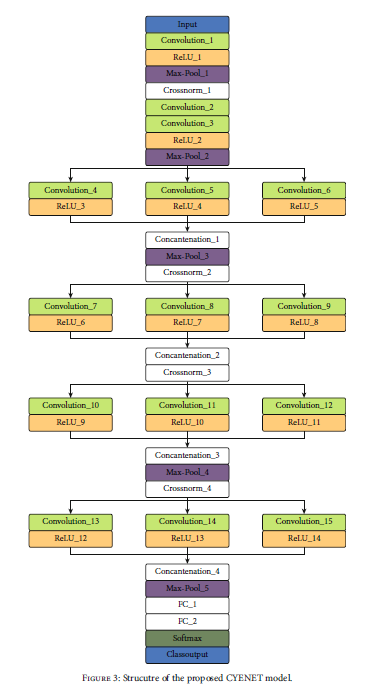

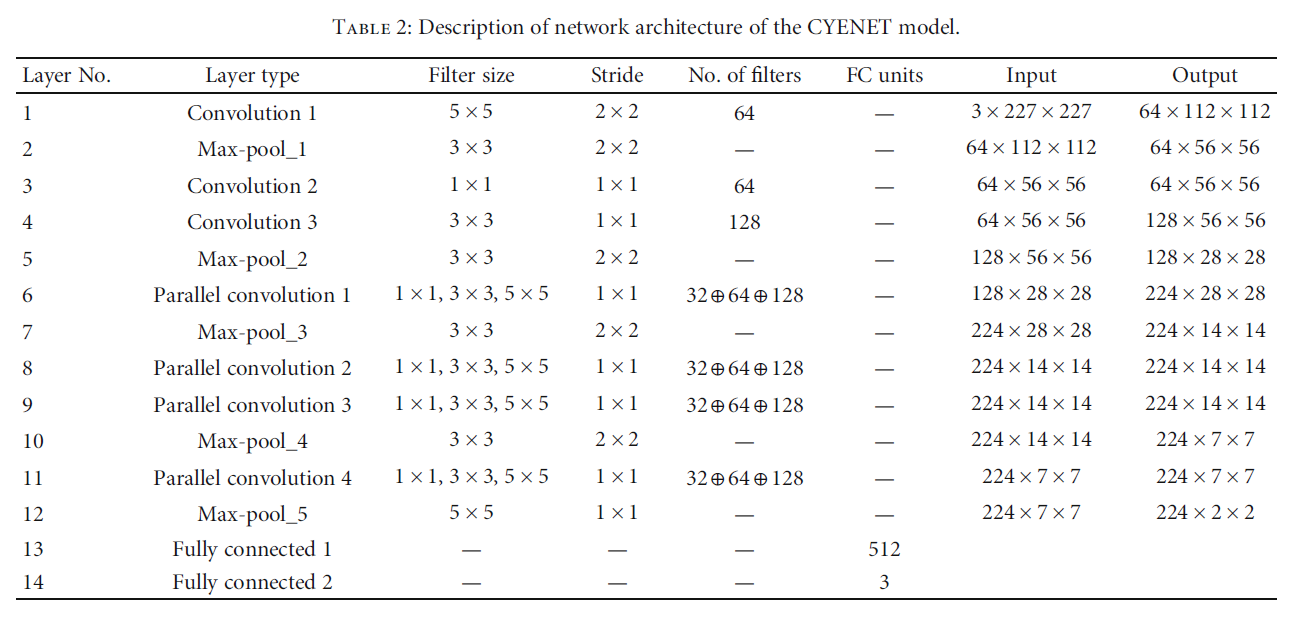

In [4]:
# Define class names
class_names = list(['Type 1','Type 2','Type 3'])

# Parallel convolution block
def parallel_conv_block(x_in):
    # First convolutional branch
    conv1 = Conv2D(32, 3, padding='same')(x_in)
    conv1 = Activation('relu')(conv1)
    
    # Second convolutional branch
    conv2 = Conv2D(64, 3, padding='same')(x_in)
    conv2 = Activation('relu')(conv2)
    
    # Third convolutional branch
    conv3 = Conv2D(128, 3, padding='same')(x_in)
    conv3 = Activation('relu')(conv3)
    
    # Concatenate the outputs of the three branches
    x_out = Concatenate()([conv1, conv2, conv3])
    
    return x_out

# Define the input shape
input_shape = x_train[0].shape

# Define the input tensor
inputs = Input(shape=input_shape)


# First Convolutional Block
x = Conv2D(64, 5, strides=2)(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, 1, strides=1)(x)
x = Conv2D(128, 3, strides=1, padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
# First parallel convolution
x = parallel_conv_block(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
# Second parallel convolution
x = parallel_conv_block(x)
x = BatchNormalization()(x)
# Third parallel convolution
x = parallel_conv_block(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
# Fourth parallel convolution
x = parallel_conv_block(x)
x = MaxPooling2D(pool_size=5, strides=2)(x)

# Flatten before dense layers
x = Flatten()(x)

# Output layers fully connected with random initialization
x = Dense(512, activation='relu', kernel_initializer='random_uniform')(x)
x = Dense(len(class_names), kernel_initializer='random_uniform')(x)
outputs = Activation('softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  4864        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [5]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="CYENETreplicated.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=600,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

# Train Model

In [6]:
# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    new_lr = lr * 0.01 if epoch % 10 == 0 else lr
    return new_lr

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 50
batch_size = 64
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val,y_val_encoded),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback],
                    shuffle=True
                   )

Epoch 1/50
131/131 [==============================] - 24s 68ms/step - loss: 1.1322 - accuracy: 0.3710 - val_loss: 1.0903 - val_accuracy: 0.3778 - lr: 1.0000e-06
Epoch 2/50
131/131 [==============================] - 7s 51ms/step - loss: 1.0686 - accuracy: 0.4300 - val_loss: 1.0587 - val_accuracy: 0.4314 - lr: 1.0000e-06
Epoch 3/50
131/131 [==============================] - 7s 51ms/step - loss: 1.0468 - accuracy: 0.4522 - val_loss: 1.0357 - val_accuracy: 0.4573 - lr: 1.0000e-06
Epoch 4/50
131/131 [==============================] - 7s 50ms/step - loss: 1.0312 - accuracy: 0.4759 - val_loss: 1.0198 - val_accuracy: 0.4803 - lr: 1.0000e-06
Epoch 5/50
131/131 [==============================] - 7s 50ms/step - loss: 1.0169 - accuracy: 0.4869 - val_loss: 1.0079 - val_accuracy: 0.5019 - lr: 1.0000e-06
Epoch 6/50
131/131 [==============================] - 7s 50ms/step - loss: 1.0070 - accuracy: 0.5017 - val_loss: 0.9985 - val_accuracy: 0.5110 - lr: 1.0000e-06
Epoch 7/50
131/131 [===================

# Evaluate Model

In [7]:
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

82/82 [==============================] - 1s 14ms/step - loss: 0.9661 - accuracy: 0.5449
Test loss: 0.9661
Test accuracy: 0.5449


# Classification Report

In [8]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

82/82 [==============================] - 1s 8ms/step
Classification Report:
               precision    recall  f1-score   support

      Type 1       0.62      0.59      0.61       886
      Type 2       0.45      0.41      0.43       826
      Type 3       0.55      0.62      0.58       896

    accuracy                           0.54      2608
   macro avg       0.54      0.54      0.54      2608
weighted avg       0.54      0.54      0.54      2608



# Confusion Matrix

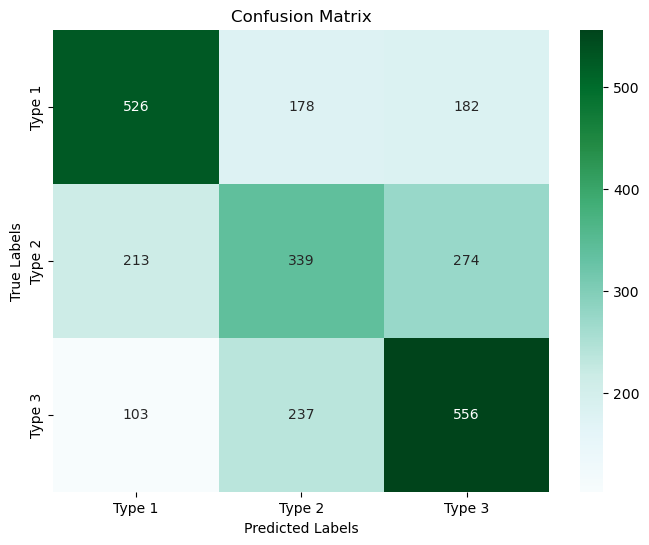

In [9]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Taining Curves

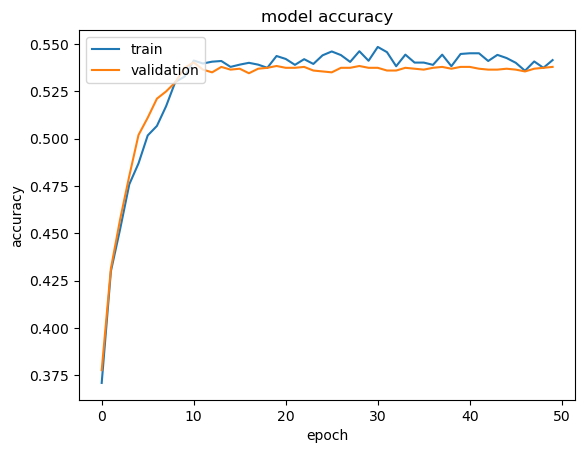

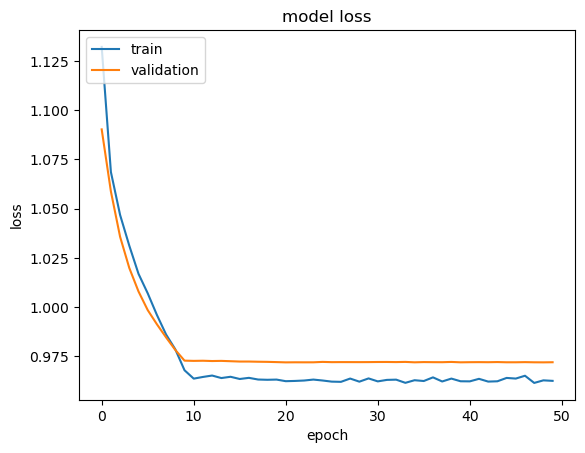

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()